In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 100356    
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_fine tuning_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=150, 
            epochs=50, 
            validation_data=(X_val,y_val), 
            validation_steps=32, 
            callbacks=[checkpoint])

Epoch 1/50
150/150 [==============================] - 44s 295ms/step - loss: 1.2527 - acc: 0.4248 - auc: 0.6236 - precision: 0.3622 - recall: 0.0216 - f1score: 0.1143 - val_loss: 1.1502 - val_acc: 0.4750 - val_auc: 0.7104 - val_precision: 0.6961 - val_recall: 0.0507 - val_f1score: 0.1229
Epoch 2/50
150/150 [==============================] - 40s 266ms/step - loss: 1.0866 - acc: 0.4971 - auc: 0.7415 - precision: 0.7397 - recall: 0.0813 - f1score: 0.1302 - val_loss: 1.0639 - val_acc: 0.5041 - val_auc: 0.7609 - val_precision: 0.7303 - val_recall: 0.1173 - val_f1score: 0.1328
Epoch 3/50
150/150 [==============================] - 41s 276ms/step - loss: 1.0177 - acc: 0.5306 - auc: 0.7739 - precision: 0.7210 - recall: 0.1396 - f1score: 0.1372 - val_loss: 1.0155 - val_acc: 0.5332 - val_auc: 0.7846 - val_precision: 0.7158 - val_recall: 0.1594 - val_f1score: 0.1370
Epoch 4/50
150/150 [==============================] - 41s 272ms/step - loss: 0.9778 - acc: 0.5523 - auc: 0.7927 - precision: 0.7165 -

150/150 [==============================] - 41s 274ms/step - loss: 0.7351 - acc: 0.6710 - auc: 0.8719 - precision: 0.7194 - recall: 0.4039 - f1score: 0.1668 - val_loss: 0.8305 - val_acc: 0.5821 - val_auc: 0.8724 - val_precision: 0.7196 - val_recall: 0.4059 - val_f1score: 0.1589
Epoch 30/50
150/150 [==============================] - 41s 272ms/step - loss: 0.7311 - acc: 0.6744 - auc: 0.8729 - precision: 0.7198 - recall: 0.4079 - f1score: 0.1673 - val_loss: 0.8248 - val_acc: 0.5856 - val_auc: 0.8734 - val_precision: 0.7202 - val_recall: 0.4098 - val_f1score: 0.1590
Epoch 31/50
150/150 [==============================] - 41s 274ms/step - loss: 0.7291 - acc: 0.6727 - auc: 0.8739 - precision: 0.7204 - recall: 0.4116 - f1score: 0.1676 - val_loss: 0.8271 - val_acc: 0.5867 - val_auc: 0.8744 - val_precision: 0.7205 - val_recall: 0.4134 - val_f1score: 0.1591
Epoch 32/50
150/150 [==============================] - 41s 274ms/step - loss: 0.7241 - acc: 0.6708 - auc: 0.8748 - precision: 0.7209 - recall:

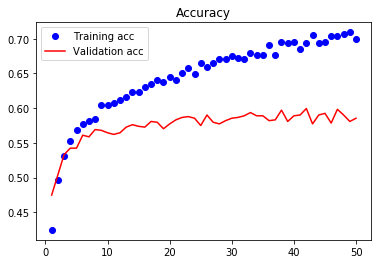

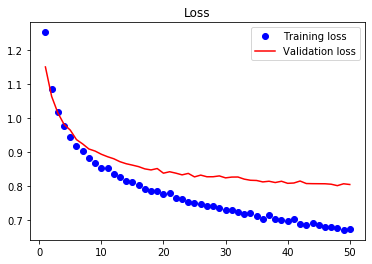

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [12]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [13]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

859/859 [==============================] - 2s 3ms/step
loss: 0.805, accuracy: 0.586, auc: 0.888, precision: 0.731, recall: 0.466, f1score: 0.162


In [14]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 7668.446, accuracy: 0.241, auc: 0.887, precision: 0.730, recall: 0.466, f1score: nan


In [15]:
additional_model.save('VGG16_fine tuning_1.h5')